# GPT MODEL

Obiettivo di questo notebook è creare l'architettura di un GPT model utilizzando i componenti creati nei capitoli precedenti (tokenization, embedding e multi-head attention) e gli aaltri componenti necessari.

Verrà creato GPT-2 con 124 milioni di parametri

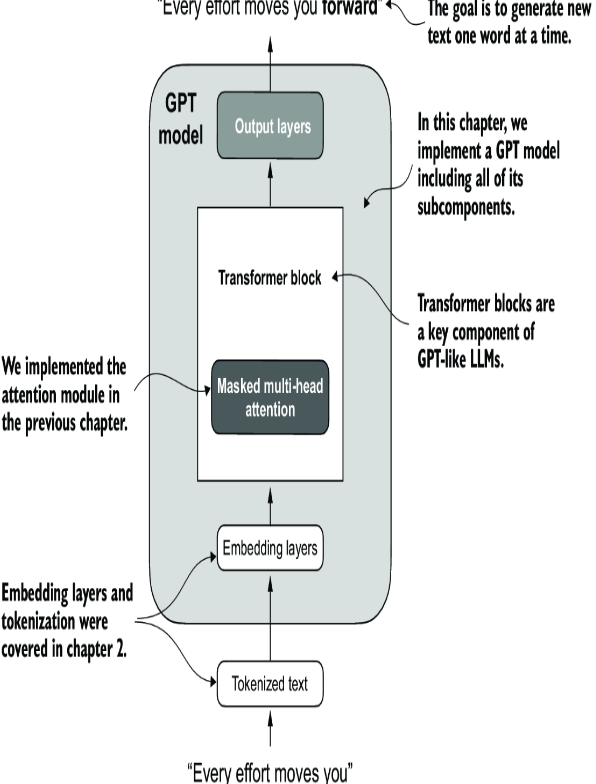

Per specificare gli iperparametri che definiscono il nostro modello creiamo un dictionary di configurazione

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size come usato da BPE tokenizer
    "context_length": 1024,  # Context length (massimo numero di token che possono essere gestiti dal modello)
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers (numero di transformer block
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

Come primo step per la creazione del GPT, creiamo la struttura del modello stesso con alcune parti "dummy" che verranno create successivamente.

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Uses a placeholder for TransformerBlock 
        self.trf_blocks = nn.Sequential(              
            *[DummyTransformerBlock(cfg)              
              for _ in range(cfg["n_layers"])]        
        )                                             

        # Uses a placeholder for LayerNorm 
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])    
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# A simple placeholder class that will be replaced by a real TransformerBlock later 
class DummyTransformerBlock(nn.Module):   
    def __init__(self, cfg):
        super().__init__()

    # This block does nothing and just returns its input. 
    def forward(self, x):    
        return x

# A simple placeholder class that will be replaced by a real LayerNorm later 
class DummyLayerNorm(nn.Module):           

    # The parameters here are just to mimic the LayerNorm interface. 
    def __init__(self, normalized_shape, eps=1e-5):  
        super().__init__()

    def forward(self, x):
        return x

Innanzi tutto è necessario preparare l'input da passare al modello e per fare ciò andiamo a "tokenizzare" un batch composto da 2 testi. Per la tokenizzazione utilizziamo il BPE tokenizer dalla libreria tiktoken

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


Una volta creato il batch di input tokenizzato andiamo ad inizializzare il GPT con 124 milioni di parametri e passiamo il batch al modello x vedere l'output (Comunemente chiamato logits)

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


Procediamo ora ad implementare i componenti mancanti per creare il modello di GPT completo.

## LAYER NORMALIZATION

Serve per migliorare la stabilità e l'efficienza del processo di training. Consiste nel modificare gli output (activations) in modo che abbiano media = 0 e varianza = 1.<br>
Viene normalmente applicato prima e dopo il multi-head attention e prima dell'output layer finale

A scopo di test creo un tensor di input che passo ad un Sequential layer + ReLu

In [7]:
torch.manual_seed(123)

# Creates two training examples with five dimensions (features) each 
batch_example = torch.randn(2, 5)    
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Verifichiamo la media e la varianza dell'output

In [9]:
mean = out.mean(dim=-1, keepdim=True)

# Uso keepdim per mantenere le dimensioni dell'input
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


Applico ora layer normalization sugli output precedenti

In [10]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)


Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Per impedire gli errori di arrotondamento

In [11]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


E' ora possibile creare il modulo per effettuare il processo di layer Normalization

In [14]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()

        # Serve per impedire divisioni per 0
        self.eps = 1e-5
        
        # rappresentano 2 trainable parameter che vengono ottimizzati durante il training
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    # Opera sull'ultima dimensione dell'input tensor (embed dim)
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

Vediamo ora come applicare il LayerNorm al batch di esempio

In [15]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Dopo aver implementato layer normalization possiamo procedere con un altro modulo utilizzato da GPT

## GELU Activation function

E' più complessa di ReLu ma offre migliori performance per modelli complessi come LLM.

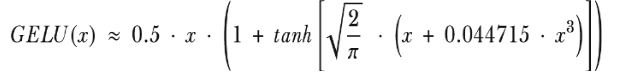

Di seguito l'implementazione in python

In [18]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

E' ora possibile utilizzare la classe GELU per implementare un modulo di FeeDForward NN che verrà successivamente utilizzato nel transformer block.

Questo modulo consiste in un piccolo Neural Network costituito da 2 LinearLayer con una GELU activation function

In [24]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


CHE può essere utilizzato per ottenere un output tensor delle stesse dimensioni dell'input tensor

In [25]:
ffn = FeedForward(GPT_CONFIG_124M)

# Creates sample input with batch dimension 2 
x = torch.rand(2, 3, 768)        
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## SHORTCUT CONNECTION

Anche dette skip o residual connection. Sono utilizzate per ridurre il problema del vanishing gradient creando un percorso alternativo per il calcolo del gradient durante la backpropagation.

Per avere un esempio del funzionamento andiamo ad implementare un NN in cui, nel metodo forward, inseriamo skip connections

In [27]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut

        #  Implements five layers 
        self.layers = nn.ModuleList([      
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
                          GELU())
        ])

    def forward(self, x):
        for layer in self.layers:

            # Compute the output of the current layer 
            layer_output = layer(x)        

            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:   
                x = x + layer_output
            else:
                x = layer_output
        return x


Prima creo il NN senza skip connections

In [28]:
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)                            #1
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

CReiamo una funzione che calcola il gradients nel backward pass

In [30]:
def print_gradients(model, x):

    # Forward pass
    output = model(x)             
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()

    #Calculates loss based on how close the target and output are 
    loss = loss(output, target)    

    # Backward pass to calculate the gradients 
    loss.backward()          

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

Ora stampiamo il gradient e vediamo che è sempre più piccolo man mano che si passa ai layer più interni

In [31]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


Utilizzando skip connections invece

In [32]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


# Transformer Block